<a href="https://colab.research.google.com/github/pascalghanimi/Injury-Prediction-in-Runners/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Data extraction for LightGBM
import pickle

with open("features.pkl", "rb") as f:
  features = pickle.load(f)

with open("features_days.pkl", "rb") as f:
  features_days = pickle.load(f)

with open("features_weeks.pkl", "rb") as f:
  features_weeks = pickle.load(f)

with open("features_objective.pkl", "rb") as f:
  features_objective = pickle.load(f)

with open("features_subjective.pkl", "rb") as f:
  features_subjective = pickle.load(f)

with open("labels.pkl", "rb") as f:
  labels = pickle.load(f)

print(features[0][0]) # first atlete first row
print(features_days[0][0])
print(features_weeks[0])
print(labels[0])

print(len(features[0][0])) # total amount of features

[ 0.77523982  0.48379555 -0.34174298  1.12482238  4.65573275 -0.30257114
 -0.36195376  1.13221076  0.88408664  0.98946749 -1.07576228 -0.58780279
 -0.34515758 -0.21498604 -0.25818757 -0.30257114 -0.36653747 -1.10832632
 -1.12373205 -1.11938273  0.76147321 -0.58880824 -0.33963599 -0.22015974
 -0.26519341  3.1128211  -0.36131219  0.94306135  0.88408664  0.88198911
 -1.08073515 -0.58890474 -0.33382237 -0.21223522 -0.26471133 -0.29617444
 -0.36131219 -1.10795815 -1.12373205 -1.11942205  0.7667035  -0.5913292
 -0.33382237 -0.22367068 -0.26509659 -0.29617444  2.42402301  0.57403001
  0.88989186  0.9965464   0.78053094  2.39956507  5.70866175 -0.21223522
 -0.26519341  3.3763886  -0.35067995  1.13636789  0.88989186  0.88771258
  0.78584128 -0.58219763 -0.3393889  -0.21762941 -0.25818757 -0.28968273
  2.19131074  0.96442407  0.89572629  0.67074481  0.37283858 -0.47040001
 -0.01179093  0.73505066  1.36358038  0.5749299   0.54093582  1.26319022
  2.68987335 -0.05530893  0.11981333  1.16084473  1.

In [20]:
import numpy as np

X = np.vstack([features[athlete_id] for athlete_id in features])
X_days = np.vstack([features_days[athlete_id] for athlete_id in features_days])
X_weeks = np.vstack([features_weeks[athlete_id] for athlete_id in features_weeks])
X_objective = np.vstack([features_objective[athlete_id] for athlete_id in features_objective])
X_subjective = np.vstack([features_subjective[athlete_id] for athlete_id in features_subjective])

Y = np.hstack([labels[athlete_id] for athlete_id in labels])


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train_days, X_temp_days, Y_train_days, Y_temp_days = train_test_split(X_days, Y, test_size=0.3, random_state=42)
X_val_days, X_test_days, Y_val_days, Y_test_days = train_test_split(X_temp_days, Y_temp_days, test_size=0.5, random_state=42)

X_train_weeks, X_temp_weeks, Y_train_weeks, Y_temp_weeks = train_test_split(X_weeks, Y, test_size=0.3, random_state=42)
X_val_weeks, X_test_weeks, Y_val_weeks, Y_test_weeks = train_test_split(X_temp_weeks, Y_temp_weeks, test_size=0.5, random_state=42)

X_train_subjective, X_temp_subjective, Y_train_subjective, Y_temp_subjective = train_test_split(X_subjective, Y, test_size=0.3, random_state=42)
X_val_subjective, X_test_subjective, Y_val_subjective, Y_test_subjective = train_test_split(X_temp_subjective, Y_temp_subjective, test_size=0.5, random_state=42)

X_train_objective, X_temp_objective, Y_train_objective, Y_temp_objective = train_test_split(X_objective, Y, test_size=0.3, random_state=42)
X_val_objective, X_test_objective, Y_val_objective, Y_test_objective = train_test_split(X_temp_objective, Y_temp_objective, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_days.shape, X_val_days.shape, X_test_days.shape)
print(X_train_weeks.shape, X_val_weeks.shape, X_test_weeks.shape)
print(X_train_subjective.shape, X_val_subjective.shape, X_test_subjective.shape)
print(X_train_objective.shape, X_val_objective.shape, X_test_objective.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)


(29876, 139) (6402, 139) (6402, 139)
(29876, 70) (6402, 70) (6402, 70)
(29876, 69) (6402, 69) (6402, 69)
(29876, 48) (6402, 48) (6402, 48)
(29876, 91) (6402, 91) (6402, 91)
(29876,) (6402,) (6402,)


In [22]:
!pip install optuna

In [23]:
def get_training_batch(X_train, Y_train, batch_size):
    injured_indices = np.where(Y_train == 1)[0]
    uninjured_indices = np.where(Y_train == 0)[0]

    injured_sample = np.random.choice(injured_indices, size=batch_size//2, replace=True)
    uninjured_sample = np.random.choice(uninjured_indices, size=batch_size//2, replace=True)

    selected_indices = np.concatenate([injured_sample, uninjured_sample])
    np.random.shuffle(selected_indices)

    X_batch = X_train[selected_indices]
    Y_batch = Y_train[selected_indices]

    return X_batch, Y_batch

In [24]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

def lightgbm_objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 7, 255),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "reg_alpha": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
        "verbose": -1
    }

    # Batch Sampling
    X_batch, Y_batch = get_training_batch(X_train, Y_train, 4096)

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_batch, Y_batch,
        eval_set=[(X_val, Y_val)],
    )

    # Validation AUC
    val_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(Y_val, val_proba)

# Optuna-Studie starten
lgb_study = optuna.create_study(direction="maximize")
lgb_study.optimize(lightgbm_objective, n_trials=100) # 100 trials

print("Best LightGBM-parameters:", lgb_study.best_params)

[I 2025-03-03 14:38:22,147] A new study created in memory with name: no-name-3282c987-5798-4f94-90b7-4cfa81dd1722
[I 2025-03-03 14:38:23,806] Trial 0 finished with value: 0.6715738836447585 and parameters: {'learning_rate': 0.014234528389219342, 'max_depth': 11, 'num_leaves': 220, 'subsample': 0.8171004823344776, 'colsample_bytree': 0.5609782045909983, 'min_child_samples': 134, 'lambda_l1': 4.407555497101805, 'lambda_l2': 4.077419205539982, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.6715738836447585.
[I 2025-03-03 14:38:26,009] Trial 1 finished with value: 0.7110327909515801 and parameters: {'learning_rate': 0.030228218913108278, 'max_depth': 10, 'num_leaves': 241, 'subsample': 0.8053659317219192, 'colsample_bytree': 0.8967185780078808, 'min_child_samples': 195, 'lambda_l1': 3.1864243299667145, 'lambda_l2': 1.4122208878574933, 'boosting_type': 'goss'}. Best is trial 1 with value: 0.7110327909515801.
[I 2025-03-03 14:38:29,486] Trial 2 finished with value: 0.696349225880418

Best LightGBM-parameters: {'learning_rate': 0.13683092812672037, 'max_depth': 6, 'num_leaves': 191, 'subsample': 0.9866010118549192, 'colsample_bytree': 0.6425656335167791, 'min_child_samples': 39, 'lambda_l1': 2.018906192294004, 'lambda_l2': 2.49363295301691, 'boosting_type': 'gbdt'}


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
import warnings

def train(X_train, Y_train, X_val, Y_val, X_test, Y_test):
  warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

  params = {**lgb_study.best_params}  # Erst in ein normales Dict umwandeln
  params.update({
      "objective": "binary",
      "metric": "auc",
      "verbose": -1
  })


  num_models = 9
  models = []
  batch_size = 4096

  for model_idx in range(num_models):
    X_batch, Y_batch = get_training_batch(X_train, Y_train, batch_size)
    model = lgb.LGBMClassifier(**params)
    model.fit(X_batch, Y_batch, eval_set=[(X_val, Y_val)])
    Y_pred_test = model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(Y_test, Y_pred_test)

    print(f"\nLightGBM Modell {model_idx + 1} Results:")
    print(f"Test-AUC: {test_auc:.4f}")
    models.append(model)

  calibrated_models = [
          CalibratedClassifierCV(m, method='sigmoid', cv="prefit").fit(X_val, Y_val) for m in models
  ]

  def ensemble_predict(models, X):
    test_probas = np.stack([m.predict_proba(X)[:, 1] for m in models])
    return np.mean(test_probas, axis=0)

  Y_probab_test = ensemble_predict(calibrated_models, X_test)
  test_auc = roc_auc_score(Y_test, Y_probab_test)

  print(f"Test-AUC of LightGBM Ensembles: {test_auc:.4f}")

  return calibrated_models, test_auc

In [35]:
# Training with all features (weeks and days combined)
lgbm_models, _ = train(X_train, Y_train, X_val, Y_val, X_test, Y_test)


LightGBM Modell 1 Results:
Test-AUC: 0.6859

LightGBM Modell 2 Results:
Test-AUC: 0.6743

LightGBM Modell 3 Results:
Test-AUC: 0.7134

LightGBM Modell 4 Results:
Test-AUC: 0.6912

LightGBM Modell 5 Results:
Test-AUC: 0.6947

LightGBM Modell 6 Results:
Test-AUC: 0.6990

LightGBM Modell 7 Results:
Test-AUC: 0.7090

LightGBM Modell 8 Results:
Test-AUC: 0.6867

LightGBM Modell 9 Results:
Test-AUC: 0.6713


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7220


In [27]:
# Training with days data
lgbm_models_days, _ = train(X_train_days, Y_train_days, X_val_days, Y_val_days, X_test_days, Y_test_days)


LightGBM Modell 1 Results:
Test-AUC: 0.6728

LightGBM Modell 2 Results:
Test-AUC: 0.6786

LightGBM Modell 3 Results:
Test-AUC: 0.6949

LightGBM Modell 4 Results:
Test-AUC: 0.6799

LightGBM Modell 5 Results:
Test-AUC: 0.6466

LightGBM Modell 6 Results:
Test-AUC: 0.6897

LightGBM Modell 7 Results:
Test-AUC: 0.6582

LightGBM Modell 8 Results:
Test-AUC: 0.6850

LightGBM Modell 9 Results:
Test-AUC: 0.6643


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6955


In [28]:
# Training with weeks data
lgbm_models_weeks, _ = train(X_train_weeks, Y_train_weeks, X_val_weeks, Y_val_weeks, X_test_weeks, Y_test_weeks)


LightGBM Modell 1 Results:
Test-AUC: 0.6756

LightGBM Modell 2 Results:
Test-AUC: 0.6657

LightGBM Modell 3 Results:
Test-AUC: 0.6808

LightGBM Modell 4 Results:
Test-AUC: 0.6505

LightGBM Modell 5 Results:
Test-AUC: 0.6647

LightGBM Modell 6 Results:
Test-AUC: 0.6751

LightGBM Modell 7 Results:
Test-AUC: 0.6784

LightGBM Modell 8 Results:
Test-AUC: 0.6685

LightGBM Modell 9 Results:
Test-AUC: 0.6896


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6939


In [29]:
# Training with objective data
lgbm_models_objective, _ = train(X_train_objective, Y_train_objective, X_val_objective, Y_val_objective, X_test_objective, Y_test_objective)


LightGBM Modell 1 Results:
Test-AUC: 0.6589

LightGBM Modell 2 Results:
Test-AUC: 0.6624

LightGBM Modell 3 Results:
Test-AUC: 0.6806

LightGBM Modell 4 Results:
Test-AUC: 0.6903

LightGBM Modell 5 Results:
Test-AUC: 0.6869

LightGBM Modell 6 Results:
Test-AUC: 0.6756

LightGBM Modell 7 Results:
Test-AUC: 0.6844

LightGBM Modell 8 Results:
Test-AUC: 0.6767

LightGBM Modell 9 Results:
Test-AUC: 0.6880


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7026


In [30]:
# Training with subjective data
lgbm_models_subjective, _ = train(X_train_subjective, Y_train_subjective, X_val_subjective, Y_val_subjective, X_test_subjective, Y_test_subjective)


LightGBM Modell 1 Results:
Test-AUC: 0.6034

LightGBM Modell 2 Results:
Test-AUC: 0.6448

LightGBM Modell 3 Results:
Test-AUC: 0.6527

LightGBM Modell 4 Results:
Test-AUC: 0.6351

LightGBM Modell 5 Results:
Test-AUC: 0.6248

LightGBM Modell 6 Results:
Test-AUC: 0.6242

LightGBM Modell 7 Results:
Test-AUC: 0.6141

LightGBM Modell 8 Results:
Test-AUC: 0.6393

LightGBM Modell 9 Results:
Test-AUC: 0.6333


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6536


In [31]:
amount_of_trainings = 10
all_auc_scores = []
auc_scores_days = []
auc_scores_weeks = []
auc_scores_objective = []
auc_scores_subjective = []

def calculate_average_auc_over_10_rounds(train_fn, auc_scores_array):
  for training in range(amount_of_trainings):
    _, auc = train_fn()
    auc_scores_array.append(auc)
  mean_auc_score = np.mean(auc_scores_array)
  std_auc_score = np.std(auc_scores_array)
  print(f"Mean AUC Score: {mean_auc_score}")
  print(f"Standard Deviation of AUC Scores: {std_auc_score}")

calculate_average_auc_over_10_rounds(lambda: train(X_train, Y_train, X_val, Y_val, X_test, Y_test), all_auc_scores)
calculate_average_auc_over_10_rounds(lambda: train(X_train_days, Y_train_days, X_val_days, Y_val_days, X_test_days, Y_test_days), auc_scores_days)
calculate_average_auc_over_10_rounds(lambda: train(X_train_weeks, Y_train_weeks, X_val_weeks, Y_val_weeks, X_test_weeks, Y_test_weeks), auc_scores_weeks)
calculate_average_auc_over_10_rounds(lambda: train(X_train_objective, Y_train_objective, X_val_objective, Y_val_objective, X_test_objective, Y_test_objective), auc_scores_objective)
calculate_average_auc_over_10_rounds(lambda: train(X_train_subjective, Y_train_subjective, X_val_subjective, Y_val_subjective, X_test_subjective, Y_test_subjective), auc_scores_subjective)


LightGBM Modell 1 Results:
Test-AUC: 0.7110

LightGBM Modell 2 Results:
Test-AUC: 0.6790

LightGBM Modell 3 Results:
Test-AUC: 0.7029

LightGBM Modell 4 Results:
Test-AUC: 0.6772

LightGBM Modell 5 Results:
Test-AUC: 0.6949

LightGBM Modell 6 Results:
Test-AUC: 0.7073

LightGBM Modell 7 Results:
Test-AUC: 0.6770

LightGBM Modell 8 Results:
Test-AUC: 0.6838

LightGBM Modell 9 Results:
Test-AUC: 0.6630


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7137

LightGBM Modell 1 Results:
Test-AUC: 0.6801

LightGBM Modell 2 Results:
Test-AUC: 0.6999

LightGBM Modell 3 Results:
Test-AUC: 0.6844

LightGBM Modell 4 Results:
Test-AUC: 0.6808

LightGBM Modell 5 Results:
Test-AUC: 0.7073

LightGBM Modell 6 Results:
Test-AUC: 0.6972

LightGBM Modell 7 Results:
Test-AUC: 0.6859

LightGBM Modell 8 Results:
Test-AUC: 0.6607

LightGBM Modell 9 Results:
Test-AUC: 0.6832


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7098

LightGBM Modell 1 Results:
Test-AUC: 0.6961

LightGBM Modell 2 Results:
Test-AUC: 0.6877

LightGBM Modell 3 Results:
Test-AUC: 0.6905

LightGBM Modell 4 Results:
Test-AUC: 0.6890

LightGBM Modell 5 Results:
Test-AUC: 0.6739

LightGBM Modell 6 Results:
Test-AUC: 0.6621

LightGBM Modell 7 Results:
Test-AUC: 0.6885

LightGBM Modell 8 Results:
Test-AUC: 0.6654

LightGBM Modell 9 Results:
Test-AUC: 0.6902


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7097

LightGBM Modell 1 Results:
Test-AUC: 0.6880

LightGBM Modell 2 Results:
Test-AUC: 0.6861

LightGBM Modell 3 Results:
Test-AUC: 0.6665

LightGBM Modell 4 Results:
Test-AUC: 0.6665

LightGBM Modell 5 Results:
Test-AUC: 0.6910

LightGBM Modell 6 Results:
Test-AUC: 0.7086

LightGBM Modell 7 Results:
Test-AUC: 0.6939

LightGBM Modell 8 Results:
Test-AUC: 0.6875

LightGBM Modell 9 Results:
Test-AUC: 0.6998


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7135

LightGBM Modell 1 Results:
Test-AUC: 0.6750

LightGBM Modell 2 Results:
Test-AUC: 0.6846

LightGBM Modell 3 Results:
Test-AUC: 0.7039

LightGBM Modell 4 Results:
Test-AUC: 0.6847

LightGBM Modell 5 Results:
Test-AUC: 0.6926

LightGBM Modell 6 Results:
Test-AUC: 0.6793

LightGBM Modell 7 Results:
Test-AUC: 0.6852

LightGBM Modell 8 Results:
Test-AUC: 0.6723

LightGBM Modell 9 Results:
Test-AUC: 0.6896


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7114

LightGBM Modell 1 Results:
Test-AUC: 0.6874

LightGBM Modell 2 Results:
Test-AUC: 0.6870

LightGBM Modell 3 Results:
Test-AUC: 0.6960

LightGBM Modell 4 Results:
Test-AUC: 0.6799

LightGBM Modell 5 Results:
Test-AUC: 0.7090

LightGBM Modell 6 Results:
Test-AUC: 0.7211

LightGBM Modell 7 Results:
Test-AUC: 0.6779

LightGBM Modell 8 Results:
Test-AUC: 0.7057

LightGBM Modell 9 Results:
Test-AUC: 0.6812


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7227

LightGBM Modell 1 Results:
Test-AUC: 0.7224

LightGBM Modell 2 Results:
Test-AUC: 0.6691

LightGBM Modell 3 Results:
Test-AUC: 0.6944

LightGBM Modell 4 Results:
Test-AUC: 0.6923

LightGBM Modell 5 Results:
Test-AUC: 0.6770

LightGBM Modell 6 Results:
Test-AUC: 0.6890

LightGBM Modell 7 Results:
Test-AUC: 0.6938

LightGBM Modell 8 Results:
Test-AUC: 0.6613

LightGBM Modell 9 Results:
Test-AUC: 0.6710


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7143

LightGBM Modell 1 Results:
Test-AUC: 0.7037

LightGBM Modell 2 Results:
Test-AUC: 0.7036

LightGBM Modell 3 Results:
Test-AUC: 0.6966

LightGBM Modell 4 Results:
Test-AUC: 0.7011

LightGBM Modell 5 Results:
Test-AUC: 0.6702

LightGBM Modell 6 Results:
Test-AUC: 0.6908

LightGBM Modell 7 Results:
Test-AUC: 0.6990

LightGBM Modell 8 Results:
Test-AUC: 0.7005

LightGBM Modell 9 Results:
Test-AUC: 0.6843


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7269

LightGBM Modell 1 Results:
Test-AUC: 0.6945

LightGBM Modell 2 Results:
Test-AUC: 0.6963

LightGBM Modell 3 Results:
Test-AUC: 0.6867

LightGBM Modell 4 Results:
Test-AUC: 0.6900

LightGBM Modell 5 Results:
Test-AUC: 0.6913

LightGBM Modell 6 Results:
Test-AUC: 0.6772

LightGBM Modell 7 Results:
Test-AUC: 0.6983

LightGBM Modell 8 Results:
Test-AUC: 0.7108

LightGBM Modell 9 Results:
Test-AUC: 0.7180


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7217

LightGBM Modell 1 Results:
Test-AUC: 0.6823

LightGBM Modell 2 Results:
Test-AUC: 0.6724

LightGBM Modell 3 Results:
Test-AUC: 0.6694

LightGBM Modell 4 Results:
Test-AUC: 0.6881

LightGBM Modell 5 Results:
Test-AUC: 0.6944

LightGBM Modell 6 Results:
Test-AUC: 0.6474

LightGBM Modell 7 Results:
Test-AUC: 0.6684

LightGBM Modell 8 Results:
Test-AUC: 0.6798

LightGBM Modell 9 Results:
Test-AUC: 0.6940


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6994
Mean AUC Score: 0.714305823582578
Standard Deviation of AUC Scores: 0.007448045904276648

LightGBM Modell 1 Results:
Test-AUC: 0.6562

LightGBM Modell 2 Results:
Test-AUC: 0.6691

LightGBM Modell 3 Results:
Test-AUC: 0.6565

LightGBM Modell 4 Results:
Test-AUC: 0.7015

LightGBM Modell 5 Results:
Test-AUC: 0.6749

LightGBM Modell 6 Results:
Test-AUC: 0.6978

LightGBM Modell 7 Results:
Test-AUC: 0.6851

LightGBM Modell 8 Results:
Test-AUC: 0.6636

LightGBM Modell 9 Results:
Test-AUC: 0.6481


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7028

LightGBM Modell 1 Results:
Test-AUC: 0.6716

LightGBM Modell 2 Results:
Test-AUC: 0.7079

LightGBM Modell 3 Results:
Test-AUC: 0.6529

LightGBM Modell 4 Results:
Test-AUC: 0.6804

LightGBM Modell 5 Results:
Test-AUC: 0.6730

LightGBM Modell 6 Results:
Test-AUC: 0.6653

LightGBM Modell 7 Results:
Test-AUC: 0.6772

LightGBM Modell 8 Results:
Test-AUC: 0.6605

LightGBM Modell 9 Results:
Test-AUC: 0.6593


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6985

LightGBM Modell 1 Results:
Test-AUC: 0.6352

LightGBM Modell 2 Results:
Test-AUC: 0.6924

LightGBM Modell 3 Results:
Test-AUC: 0.6964

LightGBM Modell 4 Results:
Test-AUC: 0.6495

LightGBM Modell 5 Results:
Test-AUC: 0.6863

LightGBM Modell 6 Results:
Test-AUC: 0.6778

LightGBM Modell 7 Results:
Test-AUC: 0.6965

LightGBM Modell 8 Results:
Test-AUC: 0.6690

LightGBM Modell 9 Results:
Test-AUC: 0.6694


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6958

LightGBM Modell 1 Results:
Test-AUC: 0.6954

LightGBM Modell 2 Results:
Test-AUC: 0.6619

LightGBM Modell 3 Results:
Test-AUC: 0.6516

LightGBM Modell 4 Results:
Test-AUC: 0.6679

LightGBM Modell 5 Results:
Test-AUC: 0.6960

LightGBM Modell 6 Results:
Test-AUC: 0.6867

LightGBM Modell 7 Results:
Test-AUC: 0.6762

LightGBM Modell 8 Results:
Test-AUC: 0.6773

LightGBM Modell 9 Results:
Test-AUC: 0.6665


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6960

LightGBM Modell 1 Results:
Test-AUC: 0.6801

LightGBM Modell 2 Results:
Test-AUC: 0.6711

LightGBM Modell 3 Results:
Test-AUC: 0.6784

LightGBM Modell 4 Results:
Test-AUC: 0.6742

LightGBM Modell 5 Results:
Test-AUC: 0.6622

LightGBM Modell 6 Results:
Test-AUC: 0.6692

LightGBM Modell 7 Results:
Test-AUC: 0.6854

LightGBM Modell 8 Results:
Test-AUC: 0.6772

LightGBM Modell 9 Results:
Test-AUC: 0.6543


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6912

LightGBM Modell 1 Results:
Test-AUC: 0.6587

LightGBM Modell 2 Results:
Test-AUC: 0.6772

LightGBM Modell 3 Results:
Test-AUC: 0.6912

LightGBM Modell 4 Results:
Test-AUC: 0.6783

LightGBM Modell 5 Results:
Test-AUC: 0.6664

LightGBM Modell 6 Results:
Test-AUC: 0.6684

LightGBM Modell 7 Results:
Test-AUC: 0.6478

LightGBM Modell 8 Results:
Test-AUC: 0.6829

LightGBM Modell 9 Results:
Test-AUC: 0.6724


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6929

LightGBM Modell 1 Results:
Test-AUC: 0.6942

LightGBM Modell 2 Results:
Test-AUC: 0.6946

LightGBM Modell 3 Results:
Test-AUC: 0.6307

LightGBM Modell 4 Results:
Test-AUC: 0.6996

LightGBM Modell 5 Results:
Test-AUC: 0.6671

LightGBM Modell 6 Results:
Test-AUC: 0.6753

LightGBM Modell 7 Results:
Test-AUC: 0.6751

LightGBM Modell 8 Results:
Test-AUC: 0.6586

LightGBM Modell 9 Results:
Test-AUC: 0.6530


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6922

LightGBM Modell 1 Results:
Test-AUC: 0.6543

LightGBM Modell 2 Results:
Test-AUC: 0.6743

LightGBM Modell 3 Results:
Test-AUC: 0.6716

LightGBM Modell 4 Results:
Test-AUC: 0.6754

LightGBM Modell 5 Results:
Test-AUC: 0.6733

LightGBM Modell 6 Results:
Test-AUC: 0.6903

LightGBM Modell 7 Results:
Test-AUC: 0.6523

LightGBM Modell 8 Results:
Test-AUC: 0.6779

LightGBM Modell 9 Results:
Test-AUC: 0.6806


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6921

LightGBM Modell 1 Results:
Test-AUC: 0.6638

LightGBM Modell 2 Results:
Test-AUC: 0.6756

LightGBM Modell 3 Results:
Test-AUC: 0.6754

LightGBM Modell 4 Results:
Test-AUC: 0.6725

LightGBM Modell 5 Results:
Test-AUC: 0.6613

LightGBM Modell 6 Results:
Test-AUC: 0.6543

LightGBM Modell 7 Results:
Test-AUC: 0.6497

LightGBM Modell 8 Results:
Test-AUC: 0.6572

LightGBM Modell 9 Results:
Test-AUC: 0.6832


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6861

LightGBM Modell 1 Results:
Test-AUC: 0.6739

LightGBM Modell 2 Results:
Test-AUC: 0.6725

LightGBM Modell 3 Results:
Test-AUC: 0.6812

LightGBM Modell 4 Results:
Test-AUC: 0.6581

LightGBM Modell 5 Results:
Test-AUC: 0.6846

LightGBM Modell 6 Results:
Test-AUC: 0.6638

LightGBM Modell 7 Results:
Test-AUC: 0.6851

LightGBM Modell 8 Results:
Test-AUC: 0.6419

LightGBM Modell 9 Results:
Test-AUC: 0.6896


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6949
Mean AUC Score: 0.6942492427388427
Standard Deviation of AUC Scores: 0.004275276572636888

LightGBM Modell 1 Results:
Test-AUC: 0.6967

LightGBM Modell 2 Results:
Test-AUC: 0.6778

LightGBM Modell 3 Results:
Test-AUC: 0.6863

LightGBM Modell 4 Results:
Test-AUC: 0.6790

LightGBM Modell 5 Results:
Test-AUC: 0.6935

LightGBM Modell 6 Results:
Test-AUC: 0.6677

LightGBM Modell 7 Results:
Test-AUC: 0.6631

LightGBM Modell 8 Results:
Test-AUC: 0.6943

LightGBM Modell 9 Results:
Test-AUC: 0.7015


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7066

LightGBM Modell 1 Results:
Test-AUC: 0.6795

LightGBM Modell 2 Results:
Test-AUC: 0.6995

LightGBM Modell 3 Results:
Test-AUC: 0.6692

LightGBM Modell 4 Results:
Test-AUC: 0.6580

LightGBM Modell 5 Results:
Test-AUC: 0.6697

LightGBM Modell 6 Results:
Test-AUC: 0.6465

LightGBM Modell 7 Results:
Test-AUC: 0.6701

LightGBM Modell 8 Results:
Test-AUC: 0.6538

LightGBM Modell 9 Results:
Test-AUC: 0.6962


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6962

LightGBM Modell 1 Results:
Test-AUC: 0.6570

LightGBM Modell 2 Results:
Test-AUC: 0.6521

LightGBM Modell 3 Results:
Test-AUC: 0.6699

LightGBM Modell 4 Results:
Test-AUC: 0.6824

LightGBM Modell 5 Results:
Test-AUC: 0.6825

LightGBM Modell 6 Results:
Test-AUC: 0.6710

LightGBM Modell 7 Results:
Test-AUC: 0.6574

LightGBM Modell 8 Results:
Test-AUC: 0.6699

LightGBM Modell 9 Results:
Test-AUC: 0.6583


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6816

LightGBM Modell 1 Results:
Test-AUC: 0.6719

LightGBM Modell 2 Results:
Test-AUC: 0.6676

LightGBM Modell 3 Results:
Test-AUC: 0.6728

LightGBM Modell 4 Results:
Test-AUC: 0.6718

LightGBM Modell 5 Results:
Test-AUC: 0.6740

LightGBM Modell 6 Results:
Test-AUC: 0.6847

LightGBM Modell 7 Results:
Test-AUC: 0.6877

LightGBM Modell 8 Results:
Test-AUC: 0.6897

LightGBM Modell 9 Results:
Test-AUC: 0.6631


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6939

LightGBM Modell 1 Results:
Test-AUC: 0.6461

LightGBM Modell 2 Results:
Test-AUC: 0.6662

LightGBM Modell 3 Results:
Test-AUC: 0.6702

LightGBM Modell 4 Results:
Test-AUC: 0.6723

LightGBM Modell 5 Results:
Test-AUC: 0.6678

LightGBM Modell 6 Results:
Test-AUC: 0.6534

LightGBM Modell 7 Results:
Test-AUC: 0.6871

LightGBM Modell 8 Results:
Test-AUC: 0.6850

LightGBM Modell 9 Results:
Test-AUC: 0.6696


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6929

LightGBM Modell 1 Results:
Test-AUC: 0.6914

LightGBM Modell 2 Results:
Test-AUC: 0.6698

LightGBM Modell 3 Results:
Test-AUC: 0.6803

LightGBM Modell 4 Results:
Test-AUC: 0.6631

LightGBM Modell 5 Results:
Test-AUC: 0.6844

LightGBM Modell 6 Results:
Test-AUC: 0.6847

LightGBM Modell 7 Results:
Test-AUC: 0.6841

LightGBM Modell 8 Results:
Test-AUC: 0.6877

LightGBM Modell 9 Results:
Test-AUC: 0.6491


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6923

LightGBM Modell 1 Results:
Test-AUC: 0.6642

LightGBM Modell 2 Results:
Test-AUC: 0.6727

LightGBM Modell 3 Results:
Test-AUC: 0.6881

LightGBM Modell 4 Results:
Test-AUC: 0.6867

LightGBM Modell 5 Results:
Test-AUC: 0.6977

LightGBM Modell 6 Results:
Test-AUC: 0.6798

LightGBM Modell 7 Results:
Test-AUC: 0.6861

LightGBM Modell 8 Results:
Test-AUC: 0.7174

LightGBM Modell 9 Results:
Test-AUC: 0.6829


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7100

LightGBM Modell 1 Results:
Test-AUC: 0.6935

LightGBM Modell 2 Results:
Test-AUC: 0.6698

LightGBM Modell 3 Results:
Test-AUC: 0.6706

LightGBM Modell 4 Results:
Test-AUC: 0.6705

LightGBM Modell 5 Results:
Test-AUC: 0.6709

LightGBM Modell 6 Results:
Test-AUC: 0.6667

LightGBM Modell 7 Results:
Test-AUC: 0.6714

LightGBM Modell 8 Results:
Test-AUC: 0.6756

LightGBM Modell 9 Results:
Test-AUC: 0.6869


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6980

LightGBM Modell 1 Results:
Test-AUC: 0.6734

LightGBM Modell 2 Results:
Test-AUC: 0.6587

LightGBM Modell 3 Results:
Test-AUC: 0.6443

LightGBM Modell 4 Results:
Test-AUC: 0.6826

LightGBM Modell 5 Results:
Test-AUC: 0.6900

LightGBM Modell 6 Results:
Test-AUC: 0.6723

LightGBM Modell 7 Results:
Test-AUC: 0.6798

LightGBM Modell 8 Results:
Test-AUC: 0.6826

LightGBM Modell 9 Results:
Test-AUC: 0.6484


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6896

LightGBM Modell 1 Results:
Test-AUC: 0.6722

LightGBM Modell 2 Results:
Test-AUC: 0.6736

LightGBM Modell 3 Results:
Test-AUC: 0.6462

LightGBM Modell 4 Results:
Test-AUC: 0.6742

LightGBM Modell 5 Results:
Test-AUC: 0.6713

LightGBM Modell 6 Results:
Test-AUC: 0.6741

LightGBM Modell 7 Results:
Test-AUC: 0.6678

LightGBM Modell 8 Results:
Test-AUC: 0.6997

LightGBM Modell 9 Results:
Test-AUC: 0.6763


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6948
Mean AUC Score: 0.6955881903901117
Standard Deviation of AUC Scores: 0.007660915827228629

LightGBM Modell 1 Results:
Test-AUC: 0.6806

LightGBM Modell 2 Results:
Test-AUC: 0.6836

LightGBM Modell 3 Results:
Test-AUC: 0.6613

LightGBM Modell 4 Results:
Test-AUC: 0.6781

LightGBM Modell 5 Results:
Test-AUC: 0.6552

LightGBM Modell 6 Results:
Test-AUC: 0.6948

LightGBM Modell 7 Results:
Test-AUC: 0.6827

LightGBM Modell 8 Results:
Test-AUC: 0.6771

LightGBM Modell 9 Results:
Test-AUC: 0.6856


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6980

LightGBM Modell 1 Results:
Test-AUC: 0.6991

LightGBM Modell 2 Results:
Test-AUC: 0.6835

LightGBM Modell 3 Results:
Test-AUC: 0.6854

LightGBM Modell 4 Results:
Test-AUC: 0.6694

LightGBM Modell 5 Results:
Test-AUC: 0.6888

LightGBM Modell 6 Results:
Test-AUC: 0.6723

LightGBM Modell 7 Results:
Test-AUC: 0.6937

LightGBM Modell 8 Results:
Test-AUC: 0.6865

LightGBM Modell 9 Results:
Test-AUC: 0.6781


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7096

LightGBM Modell 1 Results:
Test-AUC: 0.6540

LightGBM Modell 2 Results:
Test-AUC: 0.6816

LightGBM Modell 3 Results:
Test-AUC: 0.6836

LightGBM Modell 4 Results:
Test-AUC: 0.6805

LightGBM Modell 5 Results:
Test-AUC: 0.6688

LightGBM Modell 6 Results:
Test-AUC: 0.6596

LightGBM Modell 7 Results:
Test-AUC: 0.7059

LightGBM Modell 8 Results:
Test-AUC: 0.6838

LightGBM Modell 9 Results:
Test-AUC: 0.6817


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7043

LightGBM Modell 1 Results:
Test-AUC: 0.6807

LightGBM Modell 2 Results:
Test-AUC: 0.6702

LightGBM Modell 3 Results:
Test-AUC: 0.6923

LightGBM Modell 4 Results:
Test-AUC: 0.6989

LightGBM Modell 5 Results:
Test-AUC: 0.6906

LightGBM Modell 6 Results:
Test-AUC: 0.6921

LightGBM Modell 7 Results:
Test-AUC: 0.6744

LightGBM Modell 8 Results:
Test-AUC: 0.6849

LightGBM Modell 9 Results:
Test-AUC: 0.6951


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7122

LightGBM Modell 1 Results:
Test-AUC: 0.6752

LightGBM Modell 2 Results:
Test-AUC: 0.6782

LightGBM Modell 3 Results:
Test-AUC: 0.6838

LightGBM Modell 4 Results:
Test-AUC: 0.6886

LightGBM Modell 5 Results:
Test-AUC: 0.6549

LightGBM Modell 6 Results:
Test-AUC: 0.7015

LightGBM Modell 7 Results:
Test-AUC: 0.6788

LightGBM Modell 8 Results:
Test-AUC: 0.6928

LightGBM Modell 9 Results:
Test-AUC: 0.6784


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6983

LightGBM Modell 1 Results:
Test-AUC: 0.6772

LightGBM Modell 2 Results:
Test-AUC: 0.6978

LightGBM Modell 3 Results:
Test-AUC: 0.6586

LightGBM Modell 4 Results:
Test-AUC: 0.6913

LightGBM Modell 5 Results:
Test-AUC: 0.6760

LightGBM Modell 6 Results:
Test-AUC: 0.6486

LightGBM Modell 7 Results:
Test-AUC: 0.6704

LightGBM Modell 8 Results:
Test-AUC: 0.6903

LightGBM Modell 9 Results:
Test-AUC: 0.6686


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7003

LightGBM Modell 1 Results:
Test-AUC: 0.6710

LightGBM Modell 2 Results:
Test-AUC: 0.6607

LightGBM Modell 3 Results:
Test-AUC: 0.6970

LightGBM Modell 4 Results:
Test-AUC: 0.6749

LightGBM Modell 5 Results:
Test-AUC: 0.6668

LightGBM Modell 6 Results:
Test-AUC: 0.7018

LightGBM Modell 7 Results:
Test-AUC: 0.6772

LightGBM Modell 8 Results:
Test-AUC: 0.6854

LightGBM Modell 9 Results:
Test-AUC: 0.6620


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6971

LightGBM Modell 1 Results:
Test-AUC: 0.6792

LightGBM Modell 2 Results:
Test-AUC: 0.6707

LightGBM Modell 3 Results:
Test-AUC: 0.6884

LightGBM Modell 4 Results:
Test-AUC: 0.7047

LightGBM Modell 5 Results:
Test-AUC: 0.6583

LightGBM Modell 6 Results:
Test-AUC: 0.6620

LightGBM Modell 7 Results:
Test-AUC: 0.6474

LightGBM Modell 8 Results:
Test-AUC: 0.6799

LightGBM Modell 9 Results:
Test-AUC: 0.6843


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6976

LightGBM Modell 1 Results:
Test-AUC: 0.6681

LightGBM Modell 2 Results:
Test-AUC: 0.6877

LightGBM Modell 3 Results:
Test-AUC: 0.7009

LightGBM Modell 4 Results:
Test-AUC: 0.6690

LightGBM Modell 5 Results:
Test-AUC: 0.6902

LightGBM Modell 6 Results:
Test-AUC: 0.6595

LightGBM Modell 7 Results:
Test-AUC: 0.6759

LightGBM Modell 8 Results:
Test-AUC: 0.6868

LightGBM Modell 9 Results:
Test-AUC: 0.6741


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7014

LightGBM Modell 1 Results:
Test-AUC: 0.6878

LightGBM Modell 2 Results:
Test-AUC: 0.6696

LightGBM Modell 3 Results:
Test-AUC: 0.6823

LightGBM Modell 4 Results:
Test-AUC: 0.6727

LightGBM Modell 5 Results:
Test-AUC: 0.6894

LightGBM Modell 6 Results:
Test-AUC: 0.6700

LightGBM Modell 7 Results:
Test-AUC: 0.6623

LightGBM Modell 8 Results:
Test-AUC: 0.6995

LightGBM Modell 9 Results:
Test-AUC: 0.6771


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.7001
Mean AUC Score: 0.7018873512958936
Standard Deviation of AUC Scores: 0.004977633395125991

LightGBM Modell 1 Results:
Test-AUC: 0.6292

LightGBM Modell 2 Results:
Test-AUC: 0.6254

LightGBM Modell 3 Results:
Test-AUC: 0.6685

LightGBM Modell 4 Results:
Test-AUC: 0.6352

LightGBM Modell 5 Results:
Test-AUC: 0.6473

LightGBM Modell 6 Results:
Test-AUC: 0.6274

LightGBM Modell 7 Results:
Test-AUC: 0.6374

LightGBM Modell 8 Results:
Test-AUC: 0.6338

LightGBM Modell 9 Results:
Test-AUC: 0.6283


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6629

LightGBM Modell 1 Results:
Test-AUC: 0.6110

LightGBM Modell 2 Results:
Test-AUC: 0.6695

LightGBM Modell 3 Results:
Test-AUC: 0.6293

LightGBM Modell 4 Results:
Test-AUC: 0.6330

LightGBM Modell 5 Results:
Test-AUC: 0.6413

LightGBM Modell 6 Results:
Test-AUC: 0.6296

LightGBM Modell 7 Results:
Test-AUC: 0.6399

LightGBM Modell 8 Results:
Test-AUC: 0.6445

LightGBM Modell 9 Results:
Test-AUC: 0.6758


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6668

LightGBM Modell 1 Results:
Test-AUC: 0.6253

LightGBM Modell 2 Results:
Test-AUC: 0.6142

LightGBM Modell 3 Results:
Test-AUC: 0.6339

LightGBM Modell 4 Results:
Test-AUC: 0.6564

LightGBM Modell 5 Results:
Test-AUC: 0.6611

LightGBM Modell 6 Results:
Test-AUC: 0.6359

LightGBM Modell 7 Results:
Test-AUC: 0.6377

LightGBM Modell 8 Results:
Test-AUC: 0.6294

LightGBM Modell 9 Results:
Test-AUC: 0.6302


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6634

LightGBM Modell 1 Results:
Test-AUC: 0.6083

LightGBM Modell 2 Results:
Test-AUC: 0.6243

LightGBM Modell 3 Results:
Test-AUC: 0.6430

LightGBM Modell 4 Results:
Test-AUC: 0.6329

LightGBM Modell 5 Results:
Test-AUC: 0.6275

LightGBM Modell 6 Results:
Test-AUC: 0.6311

LightGBM Modell 7 Results:
Test-AUC: 0.6303

LightGBM Modell 8 Results:
Test-AUC: 0.6321

LightGBM Modell 9 Results:
Test-AUC: 0.6216


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6543

LightGBM Modell 1 Results:
Test-AUC: 0.6440

LightGBM Modell 2 Results:
Test-AUC: 0.5940

LightGBM Modell 3 Results:
Test-AUC: 0.6265

LightGBM Modell 4 Results:
Test-AUC: 0.6310

LightGBM Modell 5 Results:
Test-AUC: 0.6526

LightGBM Modell 6 Results:
Test-AUC: 0.6198

LightGBM Modell 7 Results:
Test-AUC: 0.6340

LightGBM Modell 8 Results:
Test-AUC: 0.6542

LightGBM Modell 9 Results:
Test-AUC: 0.6433


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6569

LightGBM Modell 1 Results:
Test-AUC: 0.6699

LightGBM Modell 2 Results:
Test-AUC: 0.6244

LightGBM Modell 3 Results:
Test-AUC: 0.6545

LightGBM Modell 4 Results:
Test-AUC: 0.6180

LightGBM Modell 5 Results:
Test-AUC: 0.6091

LightGBM Modell 6 Results:
Test-AUC: 0.6417

LightGBM Modell 7 Results:
Test-AUC: 0.6190

LightGBM Modell 8 Results:
Test-AUC: 0.6106

LightGBM Modell 9 Results:
Test-AUC: 0.6321


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6599

LightGBM Modell 1 Results:
Test-AUC: 0.6515

LightGBM Modell 2 Results:
Test-AUC: 0.6189

LightGBM Modell 3 Results:
Test-AUC: 0.6118

LightGBM Modell 4 Results:
Test-AUC: 0.6465

LightGBM Modell 5 Results:
Test-AUC: 0.6377

LightGBM Modell 6 Results:
Test-AUC: 0.6357

LightGBM Modell 7 Results:
Test-AUC: 0.6273

LightGBM Modell 8 Results:
Test-AUC: 0.6355

LightGBM Modell 9 Results:
Test-AUC: 0.6448


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6590

LightGBM Modell 1 Results:
Test-AUC: 0.6185

LightGBM Modell 2 Results:
Test-AUC: 0.6200

LightGBM Modell 3 Results:
Test-AUC: 0.6323

LightGBM Modell 4 Results:
Test-AUC: 0.6611

LightGBM Modell 5 Results:
Test-AUC: 0.6359

LightGBM Modell 6 Results:
Test-AUC: 0.6404

LightGBM Modell 7 Results:
Test-AUC: 0.6540

LightGBM Modell 8 Results:
Test-AUC: 0.6109

LightGBM Modell 9 Results:
Test-AUC: 0.6361


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6641

LightGBM Modell 1 Results:
Test-AUC: 0.6510

LightGBM Modell 2 Results:
Test-AUC: 0.6528

LightGBM Modell 3 Results:
Test-AUC: 0.6355

LightGBM Modell 4 Results:
Test-AUC: 0.6386

LightGBM Modell 5 Results:
Test-AUC: 0.6467

LightGBM Modell 6 Results:
Test-AUC: 0.6638

LightGBM Modell 7 Results:
Test-AUC: 0.6667

LightGBM Modell 8 Results:
Test-AUC: 0.6235

LightGBM Modell 9 Results:
Test-AUC: 0.6244


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6679

LightGBM Modell 1 Results:
Test-AUC: 0.6324

LightGBM Modell 2 Results:
Test-AUC: 0.6163

LightGBM Modell 3 Results:
Test-AUC: 0.6308

LightGBM Modell 4 Results:
Test-AUC: 0.6571

LightGBM Modell 5 Results:
Test-AUC: 0.6270

LightGBM Modell 6 Results:
Test-AUC: 0.6614

LightGBM Modell 7 Results:
Test-AUC: 0.6274

LightGBM Modell 8 Results:
Test-AUC: 0.6431

LightGBM Modell 9 Results:
Test-AUC: 0.6464


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.1

Test-AUC of LightGBM Ensembles: 0.6649
Mean AUC Score: 0.662007169553216
Standard Deviation of AUC Scores: 0.004157560152879595


<ipython-input-32-6773cfe052ff>:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


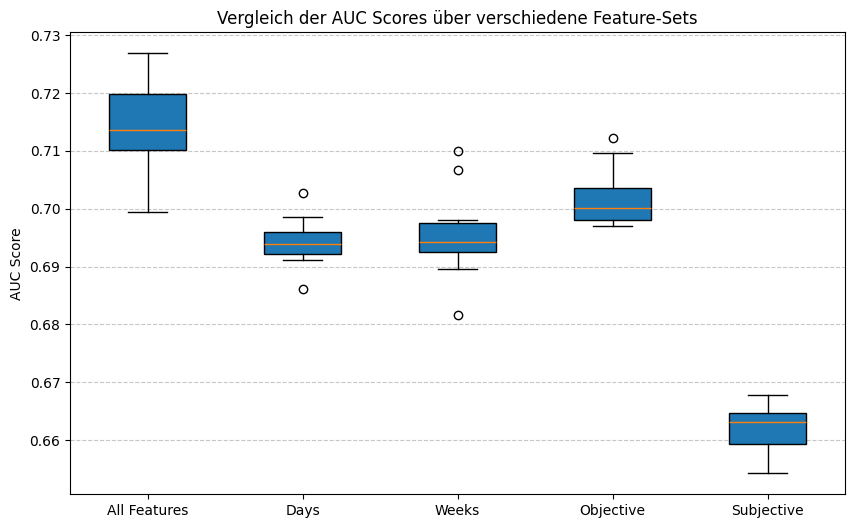

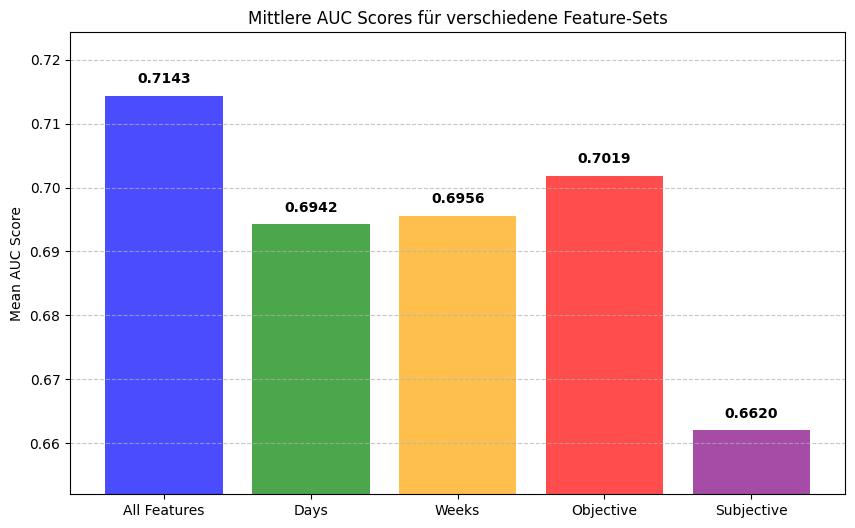

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(
    [all_auc_scores, auc_scores_days, auc_scores_weeks, auc_scores_objective, auc_scores_subjective],
    labels=["All Features", "Days", "Weeks", "Objective", "Subjective"],
    patch_artist=True
)
plt.ylabel("AUC Score")
plt.title("Vergleich der AUC Scores über verschiedene Feature-Sets")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Mean
mean_auc_scores = {
    "All Features": np.mean(all_auc_scores),
    "Days": np.mean(auc_scores_days),
    "Weeks": np.mean(auc_scores_weeks),
    "Objective": np.mean(auc_scores_objective),
    "Subjective": np.mean(auc_scores_subjective),
}

# Diagrams
plt.figure(figsize=(10, 6))
plt.bar(mean_auc_scores.keys(), mean_auc_scores.values(), color=["blue", "green", "orange", "red", "purple"], alpha=0.7)
plt.ylabel("Mean AUC Score")
plt.title("Mittlere AUC Scores für verschiedene Feature-Sets")
plt.ylim(min(mean_auc_scores.values()) - 0.01, max(mean_auc_scores.values()) + 0.01)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, v in enumerate(mean_auc_scores.values()):
    plt.text(i, v + 0.002, f"{v:.4f}", ha="center", fontsize=10, fontweight="bold")

plt.show()

In [36]:
# Single model export (only all features since it has the best probabilities overall)
import joblib
joblib.dump(lgbm_models, 'lgbm_models.pkl')

['lgbm_models.pkl']

In [37]:
# Model export for Ensemble prediction later
import joblib

joblib.dump(lgbm_models, 'lgbm_models.pkl')
joblib.dump(lgbm_models_days, 'lgbm_models_days.pkl')
joblib.dump(lgbm_models_weeks, 'lgbm_models_weeks.pkl')
joblib.dump(lgbm_models_objective, 'lgbm_models_objective.pkl')
joblib.dump(lgbm_models_subjective, 'lgbm_models_subjective.pkl')

['lgbm_models_subjective.pkl']